In [1]:
%reload_ext autoreload
%autoreload 2

from common_imports import *

In [2]:
"""
Fidelity is the inner product, except that
 each individual eigenvector product is made to be phase insensitive before summing
"""
def fidelity_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    objective = objectives[0]
    overlap = np.sum(np.abs(np.asarray(fw_states_T))*np.abs(np.asarray(objective.target)))
    return overlap

def J_T_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    J_T = 1-fidelity_custom(fw_states_T,objectives)
    return J_T


# This chi_constructor assumes there is only one objective ....
def chis_custom(fw_states_T,objectives,tau_vals=None,**kwargs):
    chis = qt.zero_ket(system.N_points*system.internal_dims,dims=[[system.N_points,system.internal_dims],[1,1]])
    chis_ls = []
    fw_states_T =  fw_states_T[0]
    objective = objectives[0]

    for s in range(system.internal_dims):
        for n in range(system.N_points):
            eigenstate = qt.tensor(qt.basis(system.N_points,n),qt.basis(2,s))
            idx = system.internal_dims*n+s
            chis_n_s = fw_states_T.extract_states(idx)*objective.target.extract_states(idx)**2*eigenstate
            chis = chis + chis_n_s
            chis_ls.append(chis_n_s)
            
    return [chis]

Quantum object: dims = [[11, 2], [11, 2]], shape = (22, 22), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0

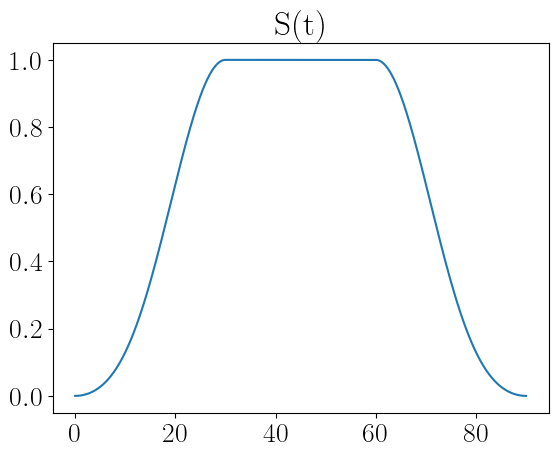

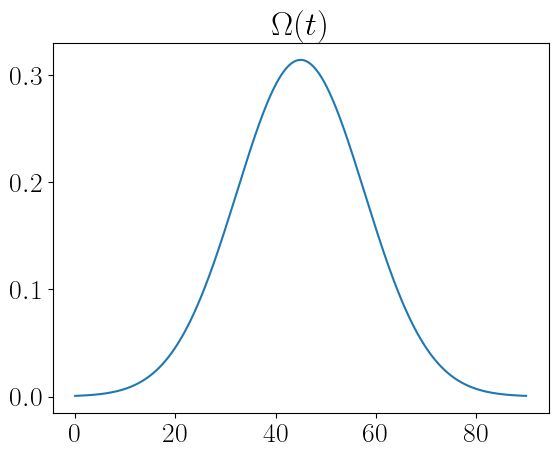

In [51]:
system = Ps_system(N_atoms = 1,N_points = 5)
rabi0 = 2*np.pi*(50e-3)
chirp = 2*np.pi*(15e-3)
detuning = 2*np.pi*(200e-3)
direction = 1
pulse_duration = 30

laser_guess = {"scale": 100,"label":"laser","order":0,"rabi0" : rabi0, "detuning0": detuning,"chirp" : chirp,"pulse_duration" : pulse_duration,"unit_wavevector":direction,"start":0,"end":int(3*pulse_duration)}
#system.init_distribution_MB()


laser = laser_new(laser_guess)
system.create_composite()
# args = {"chirp":np.asarray(laser.chirp(laser.tlist,None)),
#         "wavevector":laser.direction,
#         "rabi":np.asarray(laser.rabi(laser.tlist,None)),
#         "beating":np.asarray(laser.rabi_beating2(laser.tlist,None)),
#         "selector1":laser.selector1,
#         "selector2":laser.selector2,
#         "tlist":laser.tlist,
#         "omega_L0":laser.omega_L0}
# phi = 2*np.pi*(150e-3)+args["chirp"]
system.set_Hamiltonian_MT_general_laser(laser)
system.init_distribution_flattop()
system.init_states_ground()

basis_1S = qt.basis(system.internal_dims,0)
basis_2P = qt.basis(system.internal_dims,1)
initial_states = qt.tensor(system.DM_vel,basis_1S).unit() # define initial states to be in the ground state

oper_array = np.asarray([np.logical_and(i>0,i<=system.N_points//2+1) for i in range(system.N_points)])

oper_desymmetrize = qt.tensor(qt.qdiags(oper_array,offsets=0),qt.Qobj([[0,0],[1,0]]))# + qt.tensor(qt.qdiags(np.invert(oper_array),offsets=0),qt.Qobj([[1,0],[0,0]]))
print(oper_desymmetrize)
target_states = oper_desymmetrize.dag()*initial_states

#ground_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i >= system.N_points/2 else 0 for i in range(system.N_points)]))
#excited_kets_vel = qt.Qobj(np.asarray([target_velocity_array[i] if i < system.N_points/2 else 0 for i in range(system.N_points)]))
#target_states = (qt.tensor(ground_kets_vel,ket_1S) +qt.tensor(excited_kets_vel,ket_2P) ).unit()

H = system.H
t_start = 0
t_stop = int(pulse_duration*3)
t_rise = pulse_duration
t_fall = t_rise
lambda_a = 0.01 # detuning
lambda_b = 0.05 # envelope
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=pulse_duration*3, t_rise=pulse_duration, t_fall=pulse_duration, func='blackman'
    )
def S_zero_shape(t):
    """Shape function for no field update"""
    return krotov.shapes.zero_shape(t)

pulse_options = {id(H[1][1]): dict(lambda_a=lambda_a,update_shape=S),
                 id(H[2][1]): dict(lambda_a=lambda_b,update_shape=S_zero_shape),
                 id(H[3][1]): dict(lambda_a=lambda_b,update_shape=S)} 
objective = krotov.Objective(initial_state=initial_states, target=target_states, H=H)

plt.title("S(t)")
plt.plot(laser.tlist, [S(t) for t in laser.tlist])
plt.show()
plt.plot(laser.tlist,H[3][1])
plt.title(r"$\Omega(t)$")
plt.show()

# unopt_result = objective.propagate(laser.tlist,propagator=krotov.propagators.expm, e_ops=system.e_ops)
# fig,ax = plt.subplots()
# ax.set_title("Initial excitaiton")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,0],label="initial",color="black")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[0:system.N_points,-1],label=r"$P_g$")
# ax.plot(system.velocity_bins, np.asarray(unopt_result.expect)[system.N_points:system.N_points*2,-1],label=r"$P_e$")
# ax.set_xlabel("velocity [cm/ps]",labelpad=25)
# ax.set_ylabel("Population")
# ax.legend(fontsize=15)